In [1]:
import os
import re
import h5py
import numpy as np
import pandas as pd
import pickle as pkl
from metallum import Band, Album, Song

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Preprocessing
## Combine song lyrics with genres

In [7]:
# LYRICS_DIR = 'lyrics/'
# BANDS_DIR = 'bands/'

In [8]:
# band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
# bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
# band_genres = {b.name.lower(): b.genres for b in bands}

In [9]:
# lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
# lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
# corpus = []
# band_names = []
# song_names = []
# vocabulary = set()
# genres = []
# for band, band_lyrics in lyrics.items():
#     if band in band_genres.keys():
#         for album, album_lyrics in band_lyrics.items():
#             for song, song_lyrics in album_lyrics.items():
#                 words = []
#                 for line in song_lyrics:
#                     for w in line.split():
#                         s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
#                         if s:
#                             w = s.group()
#                             if w not in stop_words:
#                                 words.append(w)
#                 song_name = []
#                 for w in song.split():
#                     s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
#                     if s:
#                         song_name.append(s.group())
#                 song_name = ' '.join(song_name)
#                 document = ' '.join(words)
#                 if len(document) > 0:
#                     corpus.append(document)
#                     band_names.append(band)
#                     song_names.append(song_name)
#                     vocabulary.update(set(words))
#                     genres.append(band_genres[band])
# print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 170519


### Full lyrics + genres dataframe

In [10]:
# df_rows = [
#     {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
# ]
# df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
# df = df.drop_duplicates(subset=['band', 'song'])
# print(df.shape)
# df.head()

(42460, 4)


,band,song,lyrics,genres
0,aarni,myrrys,ääni tuulen varjot puiden yksinäni uneksin hal...,"[avant-garde, doom]"
1,aarni,the black keyes of r,five hundred years gone since summoned thee le...,"[avant-garde, doom]"
2,aarni,metsänpeitto sample 1 2,metsäpolulta metsän polulle metsänpeitossa for...,"[avant-garde, doom]"
3,aarni,persona mortuae cutis,yog clavis portaque cum primis digitis cutem m...,"[avant-garde, doom]"
4,aarni,ubbo,ubbo source coming zhothaqquah yok kthulhut st...,"[avant-garde, doom]"


In [2]:
df = pd.read_hdf('song-lyrics-genres.h5', key='df', mode='r')

### Statistics of song word counts

In [5]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

82.0 43.0 0 710


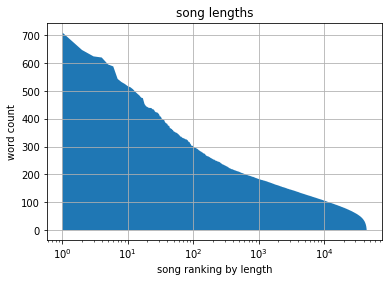

In [6]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

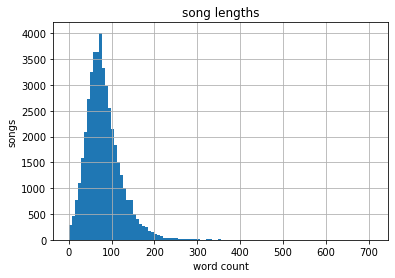

In [7]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

### Genres dataframe

In [3]:
unique_genres = []
for lst in df['genres'].tolist():
    for x in lst:
        if (x not in stop_words) and (not re.match('\-.*', x)) and (x not in unique_genres):
            unique_genres.append(x)
unique_genres.sort()

df_genres_full = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres_full[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df_genres_full['band'] = df['band'].copy()
df_genres_bands = df_genres_full.groupby('band').max()
df_genres_full.drop('band', axis=1, inplace=True)
top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.05]
df_genres = df_genres_full[top_genres].copy()

# genre_associations = {}
# for genre in unique_genres:
#     if genre not in top_genres:
#         series = df_genres_bands[df_genres_bands[genre] == 1].sum(axis=0).sort_values(ascending=False)
#         nearest_top_genre = series[series.index.isin(top_genres)]
#         if nearest_top_genre.iloc[0] > 5 and nearest_top_genre.iloc[0] > 0.5 * series.iloc[0]:
#             print(genre, nearest_top_genre.index[0], nearest_top_genre.iloc[0], series.iloc[0])
#             genre_associations[genre] = nearest_top_genre.index[0]
#             col = df_genres_full[nearest_top_genre.index[0]].copy()
#             col[df_genres_full[genre] == 1] = 1
#             df_genres_full[nearest_top_genre.index[0]] = col

# top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.1]
# df_genres = df_genres_full[top_genres].copy()
# df_genres['other'] = (df_genres.sum(axis=1) == 0).astype(int)
# # df_genres.head()

In [4]:
df_genres.mean(axis=0).sort_values(ascending=False)

death          0.324458
black          0.228039
thrash         0.192096
power          0.164412
heavy          0.163805
progressive    0.110666
melodic        0.105962
rock           0.095136
doom           0.074430
speed          0.074115
folk           0.057392
groove         0.055209
symphonic      0.051203
dtype: float64

## Tokenization & oversampling

### Train-test split lyrics and single genre label

In [5]:
corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres['power'].values, test_size=0.2)

### Transform corpuses with vectorizer fit to training corpus

In [6]:
vectorizer = CountVectorizer()
vectorizer.fit(corpus_train)
X_train = vectorizer.transform(corpus_train)
X_test = vectorizer.transform(corpus_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35544, 147204) (8887, 147204) (35544,) (8887,)


### Feature reduction

In [7]:
class FeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=0):
        self.thresh = thresh

    def fit(self, X, y=None):
        self.features = np.arange(X.shape[1])
        self.features_reduced = self.features[np.array(X.mean(axis=0) > self.thresh * X.mean()).flatten()]
        return self

    def transform(self, X):
        return X[:, self.features_reduced]

#     def transform(self, *args):
#         out = ()
#         for X in args:
#             out += (X[:, self.features_reduced],)
#         return out

feature_reducer = FeatureReducer(0)

### Cross-validation

In [21]:
def cross_validation(model, X, y, n_splits=3):
    out = {}
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = np.zeros(n_splits)
    confusion_matrices = np.zeros((n_splits, 2, 2))
    for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
        model_ = clone(model)
        model_.fit(X_fold_train, y_fold_train)
        y_fold_pred = model_.predict(X_fold_valid)
        out[i] = [y_fold_valid, y_fold_pred]
    return out

## Random forest classifier

In [22]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
random_forest = RandomForestClassifier(**rf_params)
n_splits = 5

pipeline = Pipeline(
    [
        ('featurereducer', feature_reducer),
        ('oversampler', oversampler),
        ('randomforest', random_forest)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)

In [23]:
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for k, v in results.items():
    y_fold_valid, y_fold_pred = v
    scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 71.38% +/- 1.30%
Average confusion matrix:
[[0.71615463 0.12007652]
 [0.07022282 0.09354603]]


## Logistic regression

In [94]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
lr_params = dict(
    random_state=0
)
logistic_regression = LogisticRegression(**lr_params)
n_splits = 5

pipeline = Pipeline(
    [
        ('featurereducer', feature_reducer),
        ('oversampler', oversampler),
        ('logreg', logistic_regression)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

In [95]:
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for k, v in results.items():
    y_fold_valid, y_fold_pred = v
    scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 68.40% +/- 1.47%
Average confusion matrix:
[[0.72509421 0.11166392]
 [0.08140014 0.08184173]]


## Stacked model

In [30]:
class StackedModel(BaseEstimator, TransformerMixin):
    def __init__(self, clfs=[], meta_clf=None):
        self.clfs = clfs
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)
        return self

    def predict(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        y_pred = self.meta_clf.predict(y_prob)
        return y_pred

In [31]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
random_forest = RandomForestClassifier(**rf_params)
lr_params = dict(
    random_state=0
)
logistic_regression = LogisticRegression(**lr_params)
stacked_model = StackedModel([random_forest], logistic_regression)
n_splits = 5

pipeline = Pipeline(
    [
        ('featurereducer', feature_reducer),
        ('oversampler', oversampler),
        ('stackedmodel', stacked_model)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)

D:\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

In [32]:
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for k, v in results.items():
    y_fold_valid, y_fold_pred = v
    scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 71.04% +/- 1.04%
Average confusion matrix:
[[0.72712694 0.10910421]
 [0.07348638 0.09028247]]


# Test with Keras model

In [33]:
def nn_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(40, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

def nn_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

In [34]:
epochs = 5
batch_size = 128
feature_reducer = FeatureReducer(0)
oversampler = SMOTE(random_state=0)

n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train = feature_reducer.transform(X_fold_train)
    X_fold_valid = feature_reducer.transform(X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    keras_model = KerasClassifier(
        nn_model,
        input_dim=X_fold_train.shape[1],
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0)],
        validation_data=(X_fold_valid, y_fold_valid)
    )
    keras_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = keras_model.predict(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 47556 samples, validate on 7110 samples
Epoch 1/5
47556/47556 [==============================] - 54s 1ms/step - loss: 0.3913 - binary_accuracy: 0.8555 - val_loss: 0.4891 - val_binary_accuracy: 0.7900
Epoch 2/5
47556/47556 [==============================] - 52s 1ms/step - loss: 0.1912 - binary_accuracy: 0.9276 - val_loss: 0.5316 - val_binary_accuracy: 0.8127
Train on 47556 samples, validate on 7109 samples
Epoch 1/5
47556/47556 [==============================] - 52s 1ms/step - loss: 0.3972 - binary_accuracy: 0.8527 - val_loss: 0.4705 - val_binary_accuracy: 0.8086
Epoch 2/5
47556/47556 [==============================] - 52s 1ms/step - loss: 0.2004 - binary_accuracy: 0.9254 - val_loss: 0.5135 - val_binary_accuracy: 0.8139
Train on 47556 samples, validate on 7109 samples
Epoch 1/5
47556/47556 [==============================] - 51s 1ms/step - loss: 0.4067 - binary_accuracy: 0.8497 - val_l

## Stacking RF with NN

In [159]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
random_forest = RandomForestClassifier(**rf_params)
nn_params = dict(
    epochs=1,
    batch_size=128
)
keras_nn = KerasClassifier(nn_model, input_dim=X_train.shape[1], **nn_params)
lr_params = dict(
    random_state=0
)
logistic_regression = LogisticRegression(**lr_params)
stacked_model = StackedModel([random_forest, keras_nn], logistic_regression)
n_splits = 5

pipeline = Pipeline(
    [
#         ('featurereducer', feature_reducer),
        ('oversampler', oversampler),
        ('stackedmodel', stacked_model)
    ]
)
results = cross_validation(pipeline, X_train, y_train, n_splits)

Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.3912 - binary_accuracy: 0.8296


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.4036 - binary_accuracy: 0.8233


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36380/36380 [==============================] - 61s 2ms/step - loss: 0.4031 - binary_accuracy: 0.8275


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36382/36382 [==============================] - 66s 2ms/step - loss: 0.3995 - binary_accuracy: 0.8255


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
36382/36382 [==============================] - 63s 2ms/step - loss: 0.3920 - binary_accuracy: 0.8311


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for k, v in results.items():
    y_fold_valid, y_fold_pred = v
    scores[k] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[k] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 71.72% +/- 1.04%
Average confusion matrix:
[[0.74258125 0.09417687]
 [0.07395195 0.08928992]]


In [33]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
nn_params = dict(
    epochs=1,
    batch_size=128
)
lr_params = dict(
    random_state=0
)
n_splits = 3

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))

for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train = feature_reducer.transform(X_fold_train)
    X_fold_valid = feature_reducer.transform(X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)

    rf_model = RandomForestClassifier(**rf_params)
    keras_model = KerasClassifier(nn_model, input_dim=X_fold_train.shape[1], **nn_params)
    lr_model = LogisticRegression(**lr_params)
    clfs = [rf_model, keras_model]
    meta_clf = lr_model

    stacked_model = StackedModel([rf_model, keras_model], lr_model)
    stacked_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = stacked_model.predict(X_fold_valid)

    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)

print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Epoch 1/1
30316/30316 [==============================] - 5s 149us/step - loss: 0.4279 - binary_accuracy: 0.8083


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 155us/step - loss: 0.4212 - binary_accuracy: 0.8162


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 154us/step - loss: 0.4244 - binary_accuracy: 0.8134


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV score: 71.28% +/- 1.62%
Average confusion matrix:
[[0.75691828 0.07983985]
 [0.07819124 0.08505064]]
